In [1]:
import time
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics import classification_report, accuracy_score
from subprocess import check_call
from sklearn.tree import export_graphviz
import operator
from dtreeviz.trees import *
from sklearn.datasets import load_iris
# from IPython import display

import sys
sys.path.append('..')

from Libraries.Utils.Global_Utils import *
from Libraries.SampleRemoval import *
from Libraries.ClusterMaster import *
from Libraries.DataframeTypeHolder import *

%matplotlib inline

In [2]:
def replace_df_vals(passed_df,replace_dict):
    """
        Uses a hash map to decode dataframe data
    """

    def replace_vals_col(data, decoder):
        return decoder[data]

    df = copy.deepcopy(passed_df)
    for col in df.columns:
        if col in replace_dict.keys():
            df[col] = np.vectorize(replace_vals_col)(
                df[col], replace_dict[col])

    return df

# Returns encoded df and label encoded map
def encode_df(df, objt_cols):

    df = copy.deepcopy(df)
    # ---
    le_map = defaultdict(LabelEncoder)

    # Encoding the variable
    fit = df[objt_cols].apply(lambda x: le_map[x.name].fit_transform(x))

    # Inverse the encoded
    fit.apply(lambda x: le_map[x.name].inverse_transform(x))

    # Using the dictionary to label future data
    df[objt_cols] = df[objt_cols].apply(lambda x: le_map[x.name].transform(x))

    return df, le_map

def decode_df(df,le_map):
    
    df = copy.deepcopy(df)
    decode_cols = list(le_map.keys())
    df[decode_cols] = df[decode_cols].apply(lambda x: le_map[x.name].inverse_transform(x))
    
    return df


def print_encode_map(le):

    print("\nLabel mapping:\n")
    for i, item in enumerate(le.classes_):
        print("\t", item, '-->', i)

    # Draw a line
    print("-"*30, "\n")

In [3]:
iris = load_iris()

In [4]:
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                       columns=iris['feature_names'] + ['species'])
iris_df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0

In [5]:
# http://archive.ics.uci.edu/ml/datasets/Heart+Disease
replace_dict = dict()

replace_dict["species"] = {0:"Setosa",
                           1:"Versicolor",
                           2:"Virginica"}

iris_df = replace_df_vals(iris_df,replace_dict)
iris_df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  Setosa  
1  Setosa  
2  Setosa  
3  Setosa  
4  Setosa

In [6]:
df_features = DataframeTypeHolder(iris_df)
df_features.display_all()

Categorical Features: {'species'}

Bool Features: set()

------------------------------------------------------------------------------------------
Numerical Features: {'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)', 'petal width (cm)'}

Integer Features: set()

Float Features: {'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)', 'petal width (cm)'}



In [7]:
iris_df, le_map = encode_df(iris_df, df_features.get_categorical_features())
iris_df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0

In [8]:
iris_df.values.shape

(150, 5)

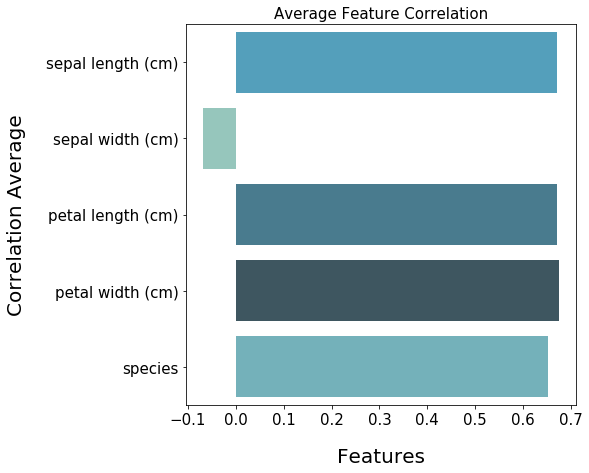

In [9]:
corr_metrics = iris_df.corr()
display(corr_metrics.style.background_gradient())

# Get the correlation means of each feature
corr_feature_means = []
for feature_name in list(corr_metrics.columns):
    corr_feature_means.append(corr_metrics[feature_name].mean())

# Graph rank
display_rank_graph(feature_names=list(corr_metrics.columns),
                   metric=corr_feature_means,
                   title="Average Feature Correlation",
                   y_title="Correlation Average",
                   x_title="Features")

In [10]:
sample_target_dict = dict()
sample_target_dict["species"] = 2


Inspecting scaled results!


Mean  Standard Dev
sepal length (cm)  2.802203e-15           1.0
sepal width (cm)  -6.136758e-16           1.0
petal length (cm) -1.010303e-15           1.0
petal width (cm)  -9.303669e-16           1.0

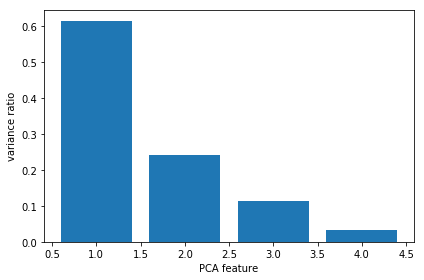

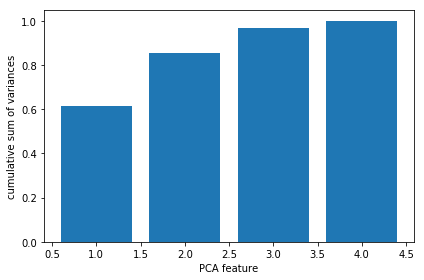


Inspecting applied pca results!


Mean  Standard Dev
PCA_Feature_1  3.552714e-17      1.566760
PCA_Feature_2  1.776357e-17      0.982198
PCA_Feature_3 -4.884981e-17      0.672512
PCA_Feature_4 -1.221245e-17      0.358160

After applying pca with a cutoff percentage of 0.8% for the cumulative index. Using features 1 to 2
Old shape (50, 4)
New shape (50, 2)

Inspecting re-applied scaled results!


Mean  Standard Dev
PCA_Feature_1  8.881784e-18           1.0
PCA_Feature_2  3.330669e-18           1.0

In [11]:
sample_remover = SampleRemoval(df=iris_df,
                               sample_target_dict=sample_target_dict,
                               columns_to_drop=list(sample_target_dict.keys()),
                               pca_perc=.8)

Scaled size is now 49 and Z-Score of 1.90
Scaled size is now 48 and Z-Score of 1.96


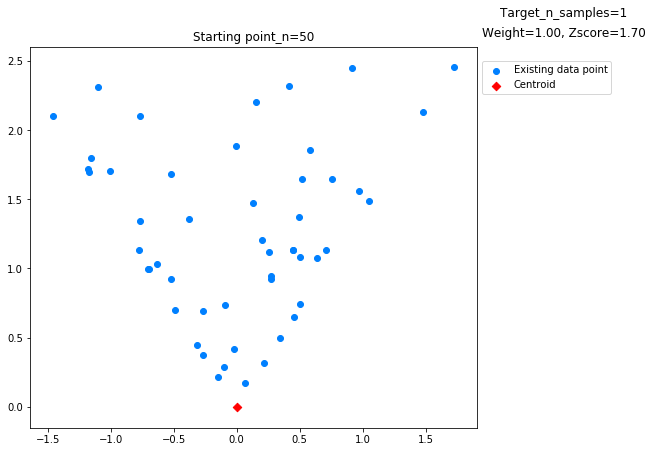

Calculating shortest distances:   0%|          | 0/1128 [00:00<?, ?it/s]

The total time required is: 0:00:00.014664


Calculating shortest distances: 100%|██████████| 1128/1128 [00:00<00:00, 10539.72it/s]


Scaled size is now 47
Scaled size is now 46
Scaled size is now 45
Scaled size is now 44
Scaled size is now 43
Scaled size is now 42
Scaled size is now 41
Scaled size is now 40
Scaled size is now 39
Scaled size is now 38
Scaled size is now 37
Scaled size is now 36
Scaled size is now 35
Scaled size is now 34
Scaled size is now 33
Scaled size is now 32
Scaled size is now 31
Scaled size is now 30
Scaled size is now 29
Scaled size is now 28
Scaled size is now 27
Scaled size is now 26
Scaled size is now 25
Scaled size is now 24
Scaled size is now 23
Scaled size is now 22
Scaled size is now 21
Scaled size is now 20
Scaled size is now 19
Scaled size is now 18
Scaled size is now 17
Scaled size is now 16
Scaled size is now 15
Scaled size is now 14
Scaled size is now 13
Scaled size is now 12
Scaled size is now 11
Scaled size is now 10
Scaled size is now 9
Scaled size is now 8
Scaled size is now 7
Scaled size is now 6
Scaled size is now 5
Scaled size is now 4
Scaled size is now 3
Scaled size is no

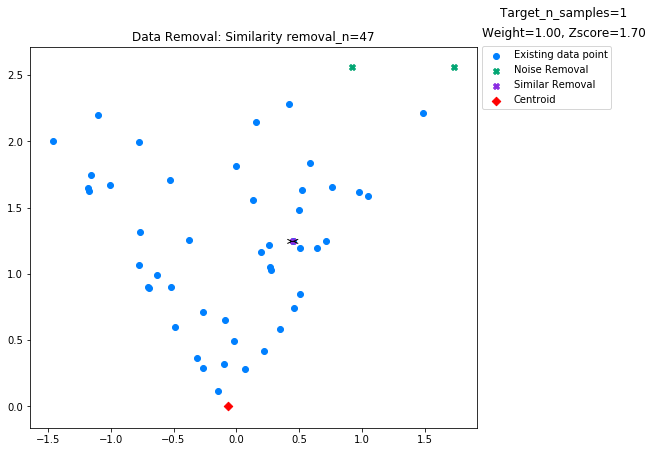

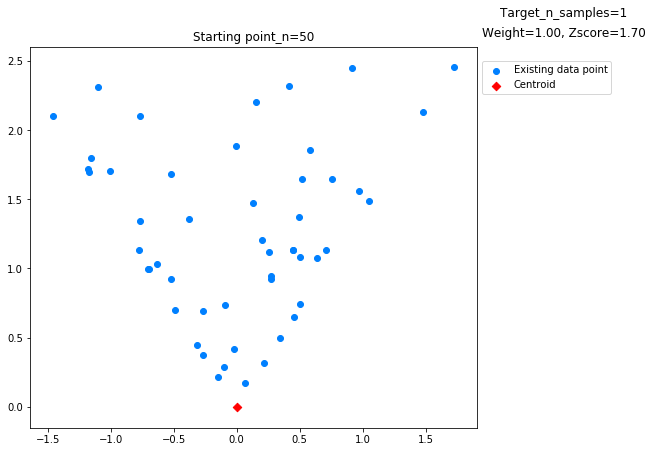

[119,
 106,
 101,
 127,
 100,
 104,
 120,
 146,
 142,
 141,
 103,
 139,
 147,
 107,
 116,
 138,
 137,
 132,
 136,
 126,
 143,
 128,
 145,
 148,
 122,
 118,
 129,
 123,
 113,
 117,
 124,
 115,
 130,
 144,
 125,
 110,
 121,
 135,
 102,
 149,
 133,
 134,
 140,
 111,
 105,
 114,
 109,
 108,
 112]

In [12]:
sample_remover.remove_samples(new_sample_amount=1,
                              zscore_high=1.7,
                              annotate=True,
                              remove_noise=True,
                              remove_similar=True,
                              weighted_dist_value=1,
                              shelve_relative_path="Shelves/Removal_df_indexes",
                              create_visuals=True,
                              show_gif=True)

In [13]:
shelf = shelve.open("Shelves/Removal_df_indexes")
print(shelf["Shelves/Removal_df_indexes".split("/")[-1]])
shelf.close()

[119, 106, 101, 127, 100, 104, 120, 146, 142, 141, 103, 139, 147, 107, 116, 138, 137, 132, 136, 126, 143, 128, 145, 148, 122, 118, 129, 123, 113, 117, 124, 115, 130, 144, 125, 110, 121, 135, 102, 149, 133, 134, 140, 111, 105, 114, 109, 108, 112]


In [14]:
scaled = sample_remover.get_scaled_data()

In [15]:
scaled[0]

array([-0.88626417, -1.47051232])

In [16]:
# index_matrix = [[i for i in range(start,tmp_len)] for start in range(0,tmp_len)][:-1]

In [17]:
np.mean(scaled[0])

-1.1783882405315305

In [18]:
index_array=[i for i in range(0,len(scaled))]
index_array
tmp_len = len(index_array)

In [19]:
index_array[0 + 1:]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [20]:
from scipy.spatial import distance
def shortest_dist_with_target(target_dp_index):
    
    distances = np.zeros(tmp_len - (target_dp_index + 1))
    for index,dp_index in enumerate(index_array[target_dp_index + 1:]):
        distances[index] = distance.euclidean(scaled[target_dp_index],
                                              scaled[dp_index])
    shortest_dp_index = np.argmin(distances)
    
    return {target_dp_index:(index_array[target_dp_index + 1:][shortest_dp_index],distances[shortest_dp_index])}

In [21]:
# 
def shortest_dist_relationship():
    
    all_shortest_distances = dict()
    for target_dp_index in range(0,index_array[-1]):
        
        all_shortest_distances = {**all_shortest_distances,
                                  **shortest_dist_with_target(target_dp_index)}
        
        
    print(all_shortest_distances)

    return min(all_shortest_distances.items(), key=lambda x: x[1][1])

In [22]:
shortest_dist_relationship()

{0: (44, 0.05093690853955943), 1: (42, 9.694605782913356e-16), 2: (25, 0.6104042728554248), 3: (16, 0.1643434094522487), 4: (39, 0.0733907384484234), 5: (18, 0.38245145538521896), 6: (13, 1.078639520512732), 7: (30, 0.20958046490888643), 8: (29, 0.5838512789505141), 9: (44, 0.860156025165083), 10: (45, 0.36237927139904524), 11: (16, 0.3790816328667832), 12: (39, 0.17385052153510078), 13: (42, 0.24489886877595549), 14: (15, 0.7965471401067362), 15: (41, 0.33492117747862454), 16: (37, 0.21387538318628202), 17: (31, 0.4773677340379911), 18: (22, 0.3738305247331038), 19: (34, 0.7643361025019588), 20: (43, 0.11560275052275028), 21: (38, 0.4428837731051357), 22: (30, 0.7862041758678651), 23: (46, 0.11805581302358609), 24: (43, 0.3056660809800229), 25: (30, 0.545496780533074), 26: (42, 0.14955144470633605), 27: (49, 0.025866909735495998), 28: (37, 0.24784211116046212), 29: (30, 0.4080008196105198), 30: (35, 1.2907735200305832), 31: (35, 0.7807648642709314), 32: (47, 0.20416707526197583), 33: 

(1, (42, 9.694605782913356e-16))

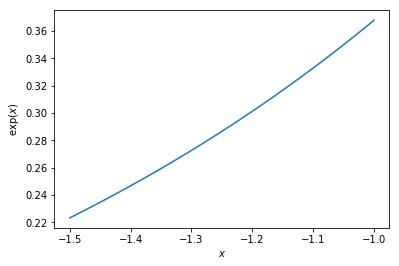

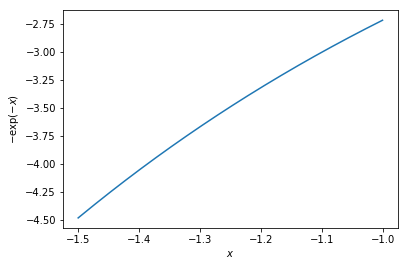

In [23]:
x = np.linspace(-1, -1.5, 200)
y = np.exp(x)

plt.figure()
plt.plot(x, y)
plt.xlabel('$x$')
plt.ylabel('$\exp(x)$')

plt.figure()
plt.plot(x, -np.exp(-x))
plt.xlabel('$x$')
plt.ylabel('$-\exp(-x)$')

plt.show()

In [24]:
dist_centroid = 1.1

In [25]:
a = [1.64021086, 1.01262395, 1.42766285, 1.16884993, 1.04884904, 2.03399206, 0.94079837]

In [26]:
centroid = np.mean(scaled, axis=0)

In [27]:
np.exp(np.linspace(-1, -1.5, 100))

array([0.36787944, 0.36602615, 0.36418219, 0.36234752, 0.3605221 ,
       0.35870587, 0.35689879, 0.35510082, 0.3533119 , 0.351532  ,
       0.34976106, 0.34799904, 0.3462459 , 0.34450159, 0.34276607,
       0.34103929, 0.33932122, 0.33761179, 0.33591098, 0.33421874,
       0.33253502, 0.33085978, 0.32919299, 0.32753459, 0.32588454,
       0.32424281, 0.32260935, 0.32098412, 0.31936707, 0.31775817,
       0.31615738, 0.31456465, 0.31297995, 0.31140322, 0.30983445,
       0.30827357, 0.30672056, 0.30517537, 0.30363796, 0.30210831,
       0.30058635, 0.29907207, 0.29756541, 0.29606634, 0.29457483,
       0.29309083, 0.2916143 , 0.29014522, 0.28868353, 0.28722921,
       0.28578221, 0.28434251, 0.28291005, 0.28148482, 0.28006676,
       0.27865585, 0.27725204, 0.27585531, 0.27446561, 0.27308292,
       0.27170719, 0.27033839, 0.26897649, 0.26762144, 0.26627323,
       0.2649318 , 0.26359714, 0.2622692 , 0.26094794, 0.25963335,
       0.25832537, 0.25702399, 0.25572916, 0.25444085, 0.25315

In [28]:
a = np.random.rand(700)
b = np.random.rand(700)

In [29]:
%timeit  distance.euclidean(a,b)

22.4 µs ± 6.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
10.4

10.4

In [31]:
expontial_amount

NameError: name 'expontial_amount' is not defined

In [ ]:
golden = (1 + 5 ** 0.5) / 2

In [ ]:
from numpy import linspace
from math import cos, sin, pi

In [ ]:
x = []
y = []
for theta in linspace(0,5*pi):
    r = ((theta)**2)
    x.append(r*cos(theta))
    y.append(r*sin(theta))

plt.plot(x,y)  
plt.show()

In [ ]:
len(x)

In [ ]:
index_array[:-1]

In [ ]:
for dp_index_key in range(40,50-1):
    print(dp_index_key)

In [ ]:
for dp_index_key in range(1-1,-1,-1):
    print(dp_index_key)

In [ ]:
total = 0
for i in range(0,48):
    total += i
print(total)
    

In [ ]:
import time
import random
from multiprocessing import Pool
import tqdm

pbar = tqdm.tqdm(total=100)

def myfunc(a):
    time.sleep(random.random())
    pbar.update(1)
    return a ** 2

pool = Pool(2)
pool.map(myfunc, range(100))
pool.close()
pool.join()
pbar.close()

In [ ]:
a = np.arange(10)
np.random.shuffle(a,random_state=2)
a

In [ ]:
np.empty([2, 2], dtype=np.array([]))